In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12692032.97it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 340116.90it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3195341.36it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3704886.96it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data = train_dataset.data.to(device).float() / 255.0
train_targets = train_dataset.targets.to(device)

test_data = test_dataset.data.to(device).float() / 255.0
test_targets = test_dataset.targets.to(device)

train_data = train_data.unsqueeze(1)
test_data = test_data.unsqueeze(1)

def get_batches(data, targets, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size], targets[i:i + batch_size]

batch_size = 6000
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
class CustomActivation(nn.Module):
    def __init__(self, num_features, num_control_points, bias_tensor, init_identity=False):
        super(CustomActivation, self).__init__()
        self.a = nn.Parameter(torch.zeros(num_features, num_control_points)).to(device)
        self.b = nn.Parameter(torch.zeros(num_features, num_control_points))
        
        self.local_bias = nn.Parameter(torch.zeros(num_features, num_control_points))
        self.global_bias = nn.Parameter(torch.zeros(1, num_features))
        # global_bias may not even be needed

        with torch.no_grad():
            repeated_bias = bias_tensor.repeat(num_features // bias_tensor.shape[0], 1)
            self.local_bias.copy_(repeated_bias)

            if init_identity:
                middle_index = num_control_points // 2
                self.a[:, middle_index] = 0.5
                self.b[:, middle_index] = 0.5

    def forward(self, x):
        x = x.unsqueeze(-1) + self.local_bias
        x = torch.where(x < 0, self.a * x, self.b * x)
        return x.sum(dim=-1) + self.global_bias

In [23]:
class CustomActivation(nn.Module):
    def __init__(self, num_features, buffer_size=10, num_control_points=9, init_identity=True):
        super(CustomActivation, self).__init__()
        self.i = 0
        self.buffer_size = buffer_size
        
        self.input_buffer = [torch.tensor(0) for _ in range(buffer_size)]
        self.quantiles = nn.Parameter(torch.linspace(0, 1, num_control_points + 2)[1:-1], requires_grad=False)
        
        self.a = nn.Parameter(torch.zeros(num_features, num_control_points))
        self.b = nn.Parameter(torch.zeros(num_features, num_control_points))
        
        self.global_bias = nn.Parameter(torch.zeros(1, num_features))
                
        with torch.no_grad():
            if init_identity:
                middle_index = num_control_points // 2
                self.a[:, middle_index] = 1.0
                self.b[:, middle_index] = 1.0

    def forward(self, x):
        if self.training:
            index = self.i % self.buffer_size
            self.input_buffer[index - 1] = self.input_buffer[index - 1].detach()            
            self.input_buffer[index] = x
            
            all_inputs = torch.cat(self.input_buffer[:min(self.i + 1, self.buffer_size)], dim=0)
            quantiles_values = torch.quantile(all_inputs, self.quantiles, dim=0)
            self.local_bias = quantiles_values.transpose(0, 1)
            
            self.i += 1
                
        x = x.unsqueeze(-1) + self.local_bias
        x = torch.where(x < 0, self.a * x, self.b * x)
        x = x.sum(dim=-1) + self.global_bias            
        return x

In [26]:
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=1, padding=3)
#         self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=3)
#         self.fc1 = nn.Linear(64 * 6 * 6, 10)

#         num_control_points = 9
#         num_features = 64 * 6 * 6
#         bias_tensor = torch.linspace(-10, 10, num_control_points).unsqueeze(0).repeat(num_features, 1)
#         self.last_act = CustomActivation(num_features, num_control_points, bias_tensor, init_identity=True)
#         self.conditioned = False

#         self.aug_pool = nn.AvgPool2d(kernel_size=2, stride=1, padding=1)        
#         self.pool = nn.MaxPool2d(2, 2)
#         self.relu = nn.ReLU()

#         nn.init.constant_(self.fc1.weight, 0)
#         nn.init.constant_(self.fc1.bias, 0)

#     def forward(self, x, i):        
#         x = self.relu(self.conv1(x))
#         x = self.pool(x)
#         x = self.relu(self.conv2(x))
#         x = self.pool(x)
#         x = self.relu(self.conv3(x))
#         x = self.pool(x)
#         x = x.view(-1, 64 * 6 * 6)
#         x = self.last_act(x)
#         x = self.fc1(x)
#         return x

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 10)

        window_size = 10

        # num_control_points = 1
        # num_features = 16 * 28 * 28
        # self.ac1 = CustomActivation(num_features, window_size, num_control_points, init_identity=True)

        # num_control_points = 1
        # num_features = 32 * 14 * 14
        # self.ac2 = CustomActivation(num_features, window_size, num_control_points, init_identity=True)

        # num_control_points = 1
        # num_features = 64 * 7 * 7
        # self.ac3 = CustomActivation(num_features, window_size, num_control_points, init_identity=True)

        self.aug_pool = nn.AvgPool2d(kernel_size=2, stride=1, padding=1)        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        nn.init.constant_(self.fc1.weight, 0)
        nn.init.constant_(self.fc1.bias, 0)

        # num_control_points = 11
        # num_features = 28 * 28
        # bias_tensor = torch.linspace(-1, 1, num_control_points).unsqueeze(0).repeat(num_features, 1)
        # self.prev_final_ac = CustomActivation(num_features, num_control_points, bias_tensor, init_identity=True)

        num_control_points = 61
        num_features = 10
        self.last_act = CustomActivation(num_features, window_size, num_control_points, init_identity=True)

        # self.final = nn.Linear(28 * 28 , 10)
        # nn.init.constant_(self.final.weight, 0)
        # nn.init.constant_(self.final.bias, 0)

    def forward(self, x, i):
        x = self.conv1(x)
        original_shape = x.size()
        x = x.view(-1, 16 * 28 * 28)
        # x = self.ac1(x)
        x = self.relu(x)
        x = x.view(original_shape)
        x = self.pool(x)
        
        x = self.conv2(x)
        original_shape = x.size()
        x = x.view(-1, 32 * 14 * 14)
        # x = self.ac2(x)
        x = self.relu(x)
        x = x.view(original_shape)        
        x = self.pool(x)
        
        x = self.conv3(x)
        x = x.view(-1, 64 * 7 * 7)
        # x = self.ac3(x)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.last_act(x)
        return x

        # x = x.view(-1, 28 * 28)
        # x = self.prev_final_ac(x)
        # x = self.final(x)
        # x = self.final_ac(x)
        # return x


learning_rate = 0.001 * 1
epochs = 1000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [28]:
bias_tensor = torch.linspace(-50, 50, 1000).unsqueeze(1).repeat(1, 10).to(device)
plot_tensor = model.last_act(bias_tensor)

In [31]:
print(model.last_act.b)

Parameter containing:
tensor([[0.0174, 0.0156, 0.0151, 0.0148, 0.0146, 0.0146, 0.0147, 0.0150, 0.0153,
         0.0158, 0.0162, 0.0167, 0.0171, 0.0176, 0.0180, 0.0184, 0.0188, 0.0193,
         0.0197, 0.0202, 0.0207, 0.0212, 0.0216, 0.0220, 0.0224, 0.0228, 0.0232,
         0.0236, 0.0240, 0.0243, 1.0247, 0.0250, 0.0254, 0.0257, 0.0259, 0.0261,
         0.0263, 0.0265, 0.0266, 0.0268, 0.0269, 0.0270, 0.0271, 0.0271, 0.0271,
         0.0270, 0.0270, 0.0268, 0.0267, 0.0265, 0.0263, 0.0261, 0.0257, 0.0253,
         0.0250, 0.0253, 0.0242, 0.0234, 0.0230, 0.0226, 0.0222],
        [0.0161, 0.0241, 0.0276, 0.0300, 0.0317, 0.0333, 0.0345, 0.0352, 0.0355,
         0.0354, 0.0351, 0.0344, 0.0336, 0.0326, 0.0315, 0.0303, 0.0292, 0.0282,
         0.0272, 0.0262, 0.0253, 0.0244, 0.0236, 0.0230, 0.0225, 0.0221, 0.0216,
         0.0213, 0.0211, 0.0209, 1.0207, 0.0206, 0.0204, 0.0203, 0.0202, 0.0201,
         0.0199, 0.0196, 0.0194, 0.0191, 0.0188, 0.0185, 0.0181, 0.0178, 0.0174,
         0.0170, 0.01

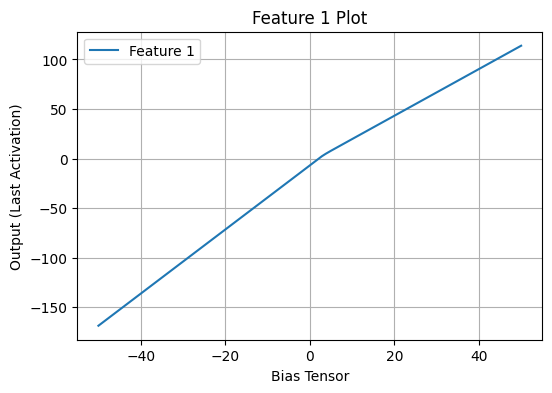

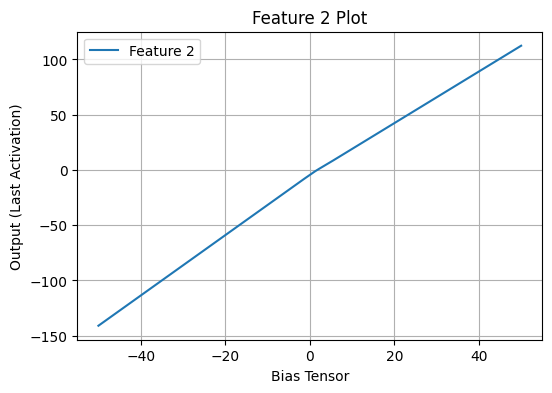

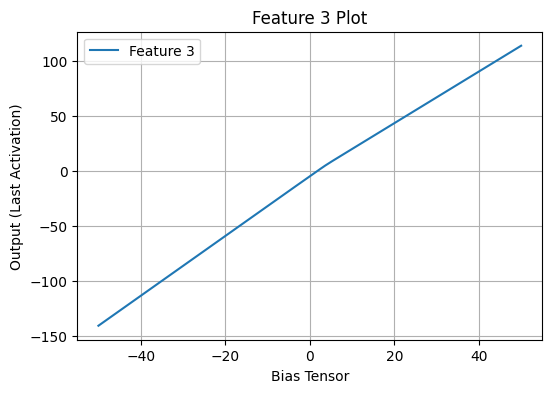

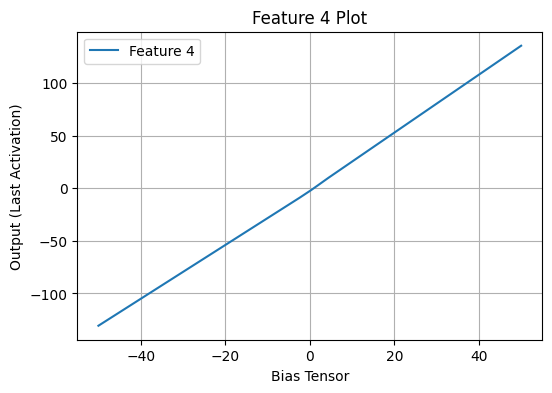

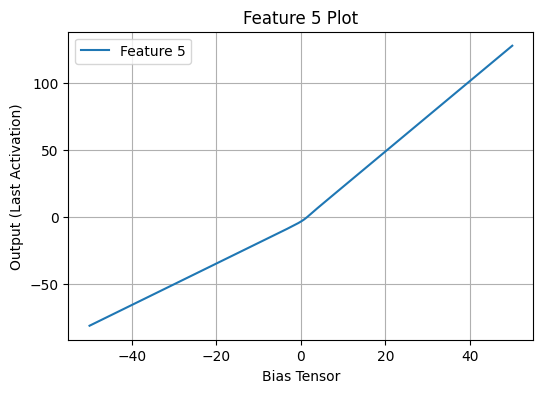

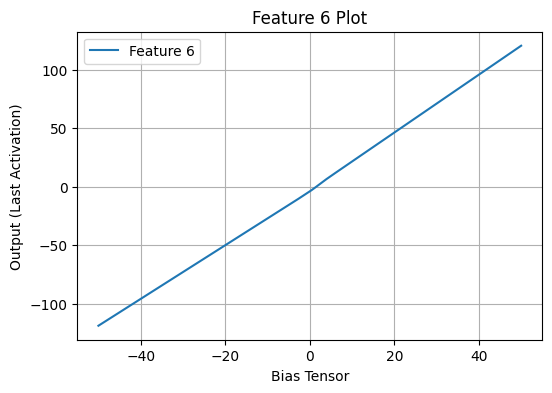

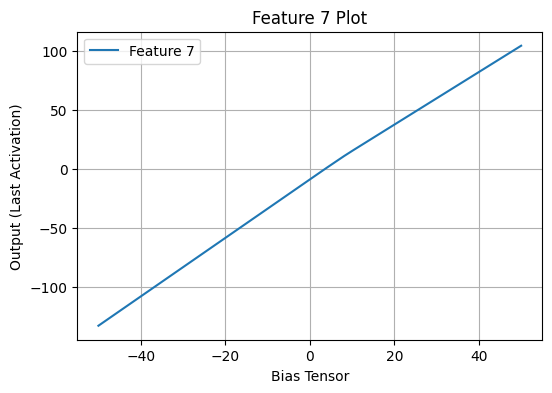

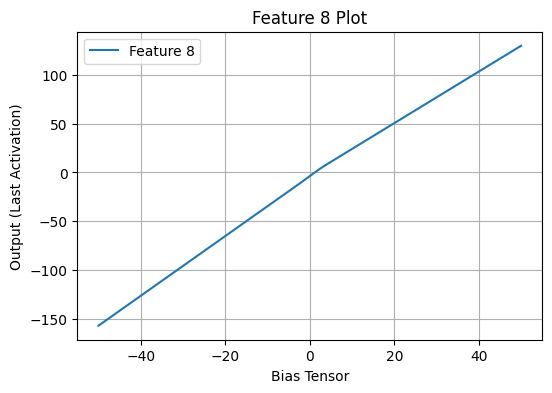

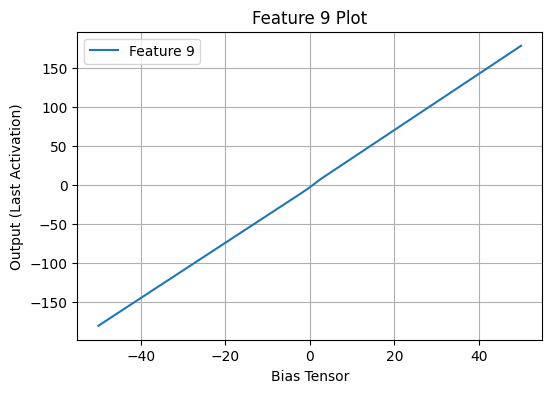

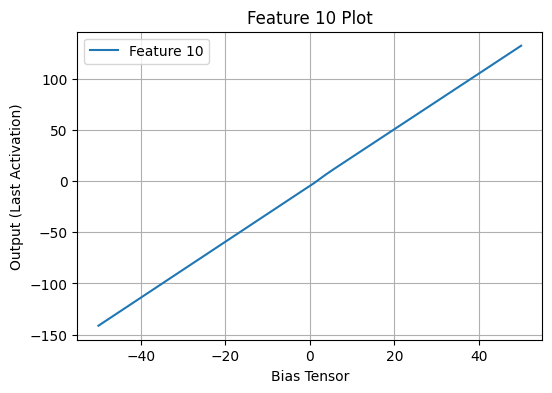

In [29]:
import matplotlib.pyplot as plt
import torch

plot_tensor_cpu = plot_tensor.detach().cpu()

for i in range(10):
    plt.figure(figsize=(6, 4))
    plt.plot(bias_tensor[:, i].cpu(), plot_tensor_cpu[:, i], label=f'Feature {i+1}')
    plt.title(f'Feature {i+1} Plot')
    plt.xlabel('Bias Tensor')
    plt.ylabel('Output (Last Activation)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# Access weights of the conv3 layer
print(model.conv3.weight.shape)
weights = model.conv3.weight.data  # Shape: [64, 32, 4, 4]

# Extract the weights of the first filter (channel 0)
first_filter = weights[0, 0, :, :]  # Shape: [kernel_size, kernel_size]

# Visualize the weights
plt.figure(figsize=(6, 6))
plt.imshow(first_filter.cpu().numpy(), cmap='gray')
plt.title('Weights of the First Filter (Channel 0) in conv3')
plt.colorbar()
plt.show()

In [27]:
patience = 20
best_val_loss = float('inf')
no_improvement_epochs = 0

all_outputs = []

for epoch in range(200):
    model.train()
    running_loss = 0.0
    num_batches = 0
    
    for data, target in get_batches(train_data, train_targets, batch_size):
        optimizer.zero_grad()
        output = model(data, epoch)
        loss = criterion(output, target)
        loss.backward()

        # Uncomment this block to add noise to gradients
        # for param in model.parameters():
        #     if param.grad is not None:
        #         noise = torch.normal(mean=0.0, std=1/(epoch + 1), size=param.grad.size()).to(param.grad.device)
        #         param.grad.add_(noise)

        optimizer.step()
        running_loss += loss.item()
        num_batches += 1

    print(f"Epoch [{epoch + 1}/{epochs}], Training Loss: {running_loss / num_batches:.4f}")

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    num_batches = 0
    epoch_outputs = []

    with torch.no_grad():
        for data, target in get_batches(test_data, test_targets, batch_size):
            outputs = model(data, 300)
            loss = criterion(outputs, target)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            num_batches += 1
            correct += (predicted == target).sum().item()

            epoch_outputs.append(outputs)

    all_outputs_tensor = torch.cat(epoch_outputs, dim=0)
    all_outputs.append(all_outputs_tensor)

    max_val = torch.max(all_outputs_tensor).item()
    min_val = torch.min(all_outputs_tensor).item()
    median_val = torch.median(all_outputs_tensor).item()
    mean_val = torch.mean(all_outputs_tensor).item()

    accuracy = 100 * correct / total
    val_loss /= num_batches
    print(f"Epoch [{epoch + 1}/{epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")
    print(f"Output Summary: Max={max_val:.4f}, Min={min_val:.4f}, Median={median_val:.4f}, Mean={mean_val:.4f}")
    print()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

Epoch [1/1000], Training Loss: 2.0638
Epoch [1/1000], Validation Loss: 1.3815, Validation Accuracy: 71.42%
Output Summary: Max=3.0835, Min=-2.8589, Median=-0.2115, Mean=-0.1571

Epoch [2/1000], Training Loss: 0.8630
Epoch [2/1000], Validation Loss: 0.5605, Validation Accuracy: 82.23%
Output Summary: Max=18.1867, Min=-19.5562, Median=-0.1381, Mean=-0.3721

Epoch [3/1000], Training Loss: 0.5456
Epoch [3/1000], Validation Loss: 0.4435, Validation Accuracy: 85.71%
Output Summary: Max=20.1889, Min=-19.0754, Median=0.2716, Mean=-0.0799

Epoch [4/1000], Training Loss: 0.4165
Epoch [4/1000], Validation Loss: 0.3454, Validation Accuracy: 89.79%
Output Summary: Max=16.1178, Min=-15.9954, Median=-0.0622, Mean=-0.1847

Epoch [5/1000], Training Loss: 0.3380
Epoch [5/1000], Validation Loss: 0.2712, Validation Accuracy: 91.45%
Output Summary: Max=18.3033, Min=-18.5681, Median=-0.4504, Mean=-0.4698

Epoch [6/1000], Training Loss: 0.2805
Epoch [6/1000], Validation Loss: 0.2380, Validation Accuracy: 92.

In [ ]:
patience = 100
best_val_loss = float('inf')
no_improvement_epochs = 0

all_outputs = []

for epoch in range(200):
    model.train()
    running_loss = 0.0
    num_batches = 0
    
    for data, target in get_batches(train_data, train_targets, batch_size):
        optimizer.zero_grad()
        output = model(data, epoch)
        loss = criterion(output, target)
        loss.backward()

        # Uncomment this block to add noise to gradients
        # for param in model.parameters():
        #     if param.grad is not None:
        #         noise = torch.normal(mean=0.0, std=1/(epoch + 1), size=param.grad.size()).to(param.grad.device)
        #         param.grad.add_(noise)

        optimizer.step()
        running_loss += loss.item()
        num_batches += 1

    print(f"Epoch [{epoch + 1}/{epochs}], Training Loss: {running_loss / num_batches:.4f}")

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    num_batches = 0
    epoch_outputs = []

    with torch.no_grad():
        for data, target in get_batches(test_data, test_targets, batch_size):
            outputs = model(data, 300)
            loss = criterion(outputs, target)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            num_batches += 1
            correct += (predicted == target).sum().item()

            epoch_outputs.append(outputs)

    all_outputs_tensor = torch.cat(epoch_outputs, dim=0)
    all_outputs.append(all_outputs_tensor)

    max_val = torch.max(all_outputs_tensor).item()
    min_val = torch.min(all_outputs_tensor).item()
    median_val = torch.median(all_outputs_tensor).item()
    mean_val = torch.mean(all_outputs_tensor).item()

    accuracy = 100 * correct / total
    val_loss /= num_batches
    print(f"Epoch [{epoch + 1}/{epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")
    print(f"Output Summary: Max={max_val:.4f}, Min={min_val:.4f}, Median={median_val:.4f}, Mean={mean_val:.4f}")
    print()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

In [ ]:
from collections import defaultdict

# Calculate and print accuracy for each class
print("\nClass-wise Accuracy:")

# Initialize dictionaries to track correct predictions and total samples per class
class_correct = defaultdict(int)
class_total = defaultdict(int)

# Evaluate class-specific accuracy
with torch.no_grad():
    for data, target in get_batches(test_data, test_targets, batch_size):
        outputs = model(data, 300)
        _, predicted = torch.max(outputs, 1)

        # Update class-specific counts
        for i in range(target.size(0)):
            label = target[i].item()
            class_total[label] += 1
            if predicted[i] == label:
                class_correct[label] += 1

# Print the accuracy for each class
for label in range(len(class_total)):  # Assuming classes are labeled 0 to number_of_classes-1
    if class_total[label] > 0:
        accuracy = 100 * class_correct[label] / class_total[label]
        print(f"Class {label}: {accuracy:.2f}%")
    else:
        print(f"Class {label}: No samples")


In [ ]:
patience = 100
best_val_loss = float('inf')
no_improvement_epochs = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    num_batches = 0
    
    for data, target in get_batches(train_data, train_targets, batch_size):
        optimizer.zero_grad()
        output = model(data, epoch)
        loss = criterion(output, target)
        loss.backward()

        for param in model.parameters():
            if param.grad is not None:
                noise = torch.normal(mean=0.0, std=noise_std, size=param.grad.size()).to(param.grad.device)
                param.grad.add_(noise)

        optimizer.step()
        running_loss += loss.item()
        num_batches += 1

    print(f"Epoch [{epoch + 1}/{epochs}], Training Loss: {running_loss / num_batches:.4f}")

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    num_batches = 0

    with torch.no_grad():
        for data, target in get_batches(test_data, test_targets, batch_size):
            outputs = model(data, 300)
            loss = criterion(outputs, target)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            num_batches += 1
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    val_loss /= num_batches
    print(f"Epoch [{epoch + 1}/{epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")
    print()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

In [ ]:
patience = 10
best_val_loss = float('inf')
no_improvement_epochs = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0 
    num_batches = 0
    
    for data, target in get_batches(train_data, train_targets, batch_size):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        num_batches += 1

    print(f"Epoch [{epoch + 1}/{epochs}], Training Loss: {running_loss / num_batches:.4f}")

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    num_batches = 0

    with torch.no_grad():
        for data, target in get_batches(test_data, test_targets, batch_size):
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            num_batches += 1
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    val_loss /= num_batches
    print(f"Epoch [{epoch + 1}/{epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")
    print()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

In [ ]:
patience = 10
best_val_loss = float('inf')
no_improvement_epochs = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    num_batches = 0
    
    for data, target in get_batches(train_data, train_targets, batch_size):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        num_batches += 1

    print(f"Epoch [{epoch + 1}/{epochs}], Training Loss: {running_loss / num_batches:.4f}")

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    num_batches = 0

    with torch.no_grad():
        for data, target in get_batches(test_data, test_targets, batch_size):
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            num_batches += 1
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    val_loss /= num_batches
    print(f"Epoch [{epoch + 1}/{epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")
    print()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

In [ ]:
model.enable_aug = False

In [ ]:
patience = 10
best_val_loss = float('inf')
no_improvement_epochs = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    num_batches = 0
    
    for data, target in get_batches(train_data, train_targets, batch_size):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        num_batches += 1

    print(f"Epoch [{epoch + 1}/{epochs}], Training Loss: {running_loss / num_batches:.4f}")

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    num_batches = 0

    with torch.no_grad():
        for data, target in get_batches(test_data, test_targets, batch_size):
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            num_batches += 1
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    val_loss /= num_batches
    print(f"Epoch [{epoch + 1}/{epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")
    print()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

In [ ]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=1, padding=3)
        self.fc1 = nn.Linear(32 * 5 * 5, 10)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        nn.init.constant_(self.fc1.weight, 0)
        nn.init.constant_(self.fc1.bias, 0)

    def forward(self, x):
        # x = x.view(x.size(0), 1, 7, 4, 7, 4).mean(dim=(3, 5))
        x = x.view(x.size(0), 1, 7, 4, 7, 4).max(dim=3)[0].max(dim=4)[0]

        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = x.view(-1, 32 * 5 * 5)
        x = self.fc1(x)
        return x

batch_size = 6000
learning_rate = 0.001 * 5
epochs = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
patience = 10
best_val_loss = float('inf')
no_improvement_epochs = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    num_batches = 0
    
    for data, target in get_batches(train_data, train_targets, batch_size):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        num_batches += 1

    print(f"Epoch [{epoch + 1}/{epochs}], Training Loss: {running_loss / num_batches:.4f}")

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    num_batches = 0

    with torch.no_grad():
        for data, target in get_batches(test_data, test_targets, batch_size):
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            num_batches += 1
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    val_loss /= num_batches
    print(f"Epoch [{epoch + 1}/{epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")
    print()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

In [ ]:
for param in model.parameters():
    param.requires_grad = False

model.eval()

In [ ]:
class SimpleCNN_2(nn.Module):
    def __init__(self):
        super(SimpleCNN_2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 8 * 8, 10)

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.aug_pool = nn.AvgPool2d(kernel_size=2, stride=1, padding=1)

        nn.init.constant_(self.fc1.weight, 0)
        nn.init.constant_(self.fc1.bias, 0)
        
    def forward(self, x):
        with torch.no_grad():
            to_add = model(x)
            
        # x = x.view(x.size(0), 1, 14, 2, 14, 2).mean(dim=(3, 5))
        # x = x.view(x.size(0), 1, 14, 2, 14, 2).max(dim=3)[0].max(dim=4)[0]
        
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = x.view(-1, 32 * 8 * 8)
        x = self.fc1(x)

        return x + to_add

batch_size = 6000
learning_rate = 0.001 * 1
epochs = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_2 = SimpleCNN_2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)

In [ ]:
patience = 10
best_val_loss = float('inf')
no_improvement_epochs = 0

for epoch in range(epochs):
    model_2.train()
    running_loss = 0.0
    num_batches = 0
    
    for data, target in get_batches(train_data, train_targets, batch_size):
        optimizer.zero_grad()
        output = model_2(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        num_batches += 1

    print(f"Epoch [{epoch + 1}/{epochs}], Training Loss: {running_loss / num_batches:.4f}")

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    num_batches = 0

    with torch.no_grad():
        for data, target in get_batches(test_data, test_targets, batch_size):
            outputs = model_2(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            num_batches += 1
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    val_loss /= num_batches
    print(f"Epoch [{epoch + 1}/{epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")
    print()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

In [ ]:
for name, param in model_2.named_parameters():
    print(name)
    print(param)

In [ ]:
for param in model_2.parameters():
    param.requires_grad = False

model_2.eval()

In [ ]:
class SimpleCNN_3(nn.Module):
    def __init__(self):
        super(SimpleCNN_3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        nn.init.constant_(self.fc2.weight, 0)
        nn.init.constant_(self.fc2.bias, 0)

    def forward(self, x):
        with torch.no_grad():
            to_add = model_2(x)
            
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return to_add + x

In [ ]:
batch_size = 6000
learning_rate = 0.001
epochs = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_3 = SimpleCNN_3().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3.parameters(), lr=learning_rate)

In [ ]:
patience = 10
best_val_loss = float('inf')
no_improvement_epochs = 0

for epoch in range(epochs):
    model_3.train()
    running_loss = 0.0
    num_batches = 0
    
    for data, target in get_batches(train_data, train_targets, batch_size):
        optimizer.zero_grad()
        output = model_3(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        num_batches += 1

    print(f"Epoch [{epoch + 1}/{epochs}], Training Loss: {running_loss / num_batches:.4f}")

    model_3.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    num_batches = 0

    with torch.no_grad():
        for data, target in get_batches(test_data, test_targets, batch_size):
            outputs = model_3(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            num_batches += 1
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    val_loss /= num_batches
    print(f"Epoch [{epoch + 1}/{epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")
    print()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break